# Probabilistic Reconciliation Methods Comparison

This notebook compares the different probabilistic reconciliation methods available in HierarchicalForecast:
- **Normality**: Gaussian-based, parametric approach
- **Bootstrap**: Non-parametric residual resampling
- **PERMBU**: Empirical copula-based with rank permutation
- **Conformal**: Distribution-free with coverage guarantees under exchangeability

In [41]:
# Install dependencies if needed
# !pip install hierarchicalforecast statsforecast

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MinTrace

## 1. Load and Prepare Data

We use the Australian Tourism dataset for this example.

In [43]:
# Load tourism data
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533


In [44]:
# Define hierarchical structure
spec = [
    ['Country'],
    ['Country', 'State'],
    ['Country', 'State', 'Region'],
]

Y_df, S_df, tags = aggregate(df=Y_df, spec=spec)
print(f"Hierarchy has {S_df.shape[0]} series ({S_df.shape[1]} bottom-level)")

Hierarchy has 85 series (77 bottom-level)


In [45]:
# Train/test split
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

print(f"Training: {len(Y_train_df)} observations")
print(f"Testing: {len(Y_test_df)} observations")

Training: 6120 observations
Testing: 680 observations


## 2. Compute Base Forecasts

In [46]:
# Fit base forecaster
fcst = StatsForecast(
    models=[AutoARIMA(season_length=4)],
    freq='QS',
    n_jobs=-1
)

# Get forecasts and fitted values for probabilistic methods
# Note: level is required for normality intervals to reverse-engineer sigmah
Y_hat_df = fcst.forecast(df=Y_train_df, h=8, fitted=True, level=[90])
Y_fitted_df = fcst.forecast_fitted_values()

## 3. Probabilistic Reconciliation Methods

### Method Comparison Table

| Method | Distributional Assumptions | Residual Usage | Reconciliation Timing | Coverage Guarantee | Hierarchy Requirement |
|--------|---------------------------|----------------|----------------------|-------------------|----------------------|
| **Normality** | Gaussian errors | Computes covariance from residuals | N/A (analytical) | Asymptotic | Any |
| **Bootstrap** | None | Block resamples raw residuals, then reconciles | After perturbation | Asymptotic | Any |
| **PERMBU** | None (uses empirical marginals) | Rank permutations for copula | Bottom-up aggregation | Asymptotic | Strictly hierarchical only |
| **Conformal** | Exchangeability | Scores from reconciled residuals | Before perturbation | Finite-sample: $(1-\alpha) \cdot n/(n+1)$ | Any |

### Key Technical Differences

**Bootstrap vs Conformal residual handling:**
- **Bootstrap**: Adds residual blocks to *raw* forecasts, then applies reconciliation (`SP @ (y_hat + residuals)`)
- **Conformal**: Computes scores from *reconciled* forecasts, adds to reconciled predictions (`y_rec + scores`)

In [47]:
# Reconcile with different probabilistic methods
# Using MinTrace for most methods, BottomUp for PERMBU (which uses bottom-up aggregation internally)
reconcilers_mintrace = [MinTrace(method='mint_shrink')]
reconcilers_bottomup = [BottomUp()]

hrec_mintrace = HierarchicalReconciliation(reconcilers=reconcilers_mintrace)
hrec_bottomup = HierarchicalReconciliation(reconcilers=reconcilers_bottomup)

In [48]:
# Normality-based intervals
Y_rec_normality = hrec_mintrace.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S_df=S_df,
    tags=tags,
    level=[90],
    intervals_method='normality'
)
print("Normality reconciliation complete")

Normality reconciliation complete


In [49]:
# Bootstrap-based intervals
Y_rec_bootstrap = hrec_mintrace.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S_df=S_df,
    tags=tags,
    level=[90],
    intervals_method='bootstrap'
)
print("Bootstrap reconciliation complete")

Bootstrap reconciliation complete


In [50]:
# PERMBU-based intervals (requires strictly hierarchical structure and BottomUp reconciler)
Y_rec_permbu = hrec_bottomup.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S_df=S_df,
    tags=tags,
    level=[90],
    intervals_method='permbu'
)
print("PERMBU reconciliation complete")

PERMBU reconciliation complete


In [51]:
# Conformal-based intervals
Y_rec_conformal = hrec_mintrace.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S_df=S_df,
    tags=tags,
    level=[90],
    intervals_method='conformal'
)
print("Conformal reconciliation complete")

Conformal reconciliation complete


## 4. Visualize Prediction Intervals

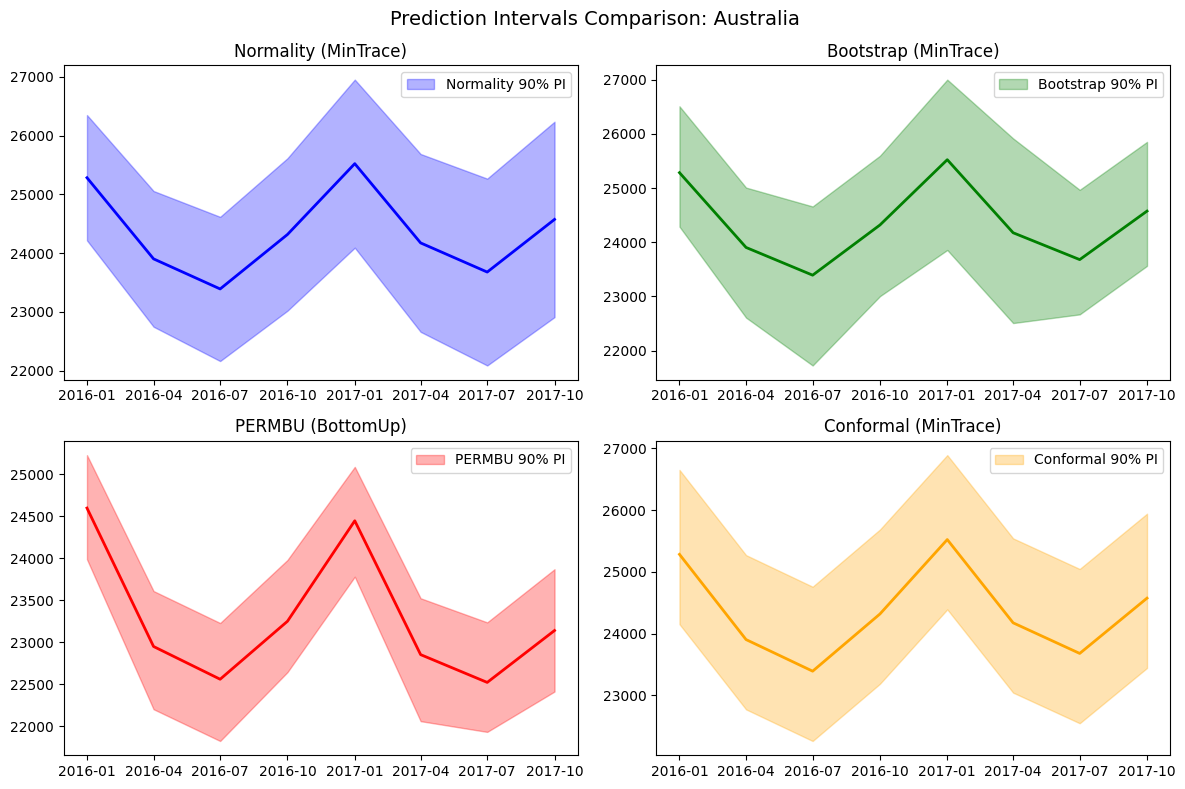

In [ ]:
def plot_intervals(series_id, ax, rec_df, method_name, color, col_mean):
    """Helper to plot prediction intervals for a series."""
    df = rec_df[rec_df['unique_id'] == series_id].copy()
    
    col_lo = f'{col_mean}-lo-90'
    col_hi = f'{col_mean}-hi-90'
    
    ax.fill_between(df['ds'], df[col_lo], df[col_hi], alpha=0.3, color=color, label=f'{method_name} 90% PI')
    ax.plot(df['ds'], df[col_mean], color=color, linewidth=2)

# Plot comparison for top-level series
series_id = 'Australia'

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# MinTrace methods use 'AutoARIMA/MinTrace_method-mint_shrink' column
col_mintrace = 'AutoARIMA/MinTrace_method-mint_shrink'
# BottomUp (PERMBU) uses 'AutoARIMA/BottomUp' column
col_bottomup = 'AutoARIMA/BottomUp'

plot_intervals(series_id, axes[0, 0], Y_rec_normality, 'Normality', 'blue', col_mintrace)
axes[0, 0].set_title('Normality (MinTrace)')
axes[0, 0].legend()

plot_intervals(series_id, axes[0, 1], Y_rec_bootstrap, 'Bootstrap', 'green', col_mintrace)
axes[0, 1].set_title('Bootstrap (MinTrace)')
axes[0, 1].legend()

plot_intervals(series_id, axes[1, 0], Y_rec_permbu, 'PERMBU', 'red', col_bottomup)
axes[1, 0].set_title('PERMBU (BottomUp)')
axes[1, 0].legend()

plot_intervals(series_id, axes[1, 1], Y_rec_conformal, 'Conformal', 'orange', col_mintrace)
axes[1, 1].set_title('Conformal (MinTrace)')
axes[1, 1].legend()

fig.suptitle(f'Prediction Intervals Comparison: {series_id}', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Evaluate Probabilistic Forecasts

We evaluate the probabilistic forecasts using the **Scaled Continuous Ranked Probability Score (CRPS)**, which measures the quality of probabilistic predictions. Lower values indicate better calibrated prediction intervals.

In [55]:
from utilsforecast.losses import scaled_crps
from hierarchicalforecast.evaluation import evaluate

# Prepare evaluation dataframes by merging with test actuals
Y_rec_normality_eval = Y_rec_normality.merge(Y_test_df, on=['unique_id', 'ds'])
Y_rec_bootstrap_eval = Y_rec_bootstrap.merge(Y_test_df, on=['unique_id', 'ds'])
Y_rec_permbu_eval = Y_rec_permbu.merge(Y_test_df, on=['unique_id', 'ds'])
Y_rec_conformal_eval = Y_rec_conformal.merge(Y_test_df, on=['unique_id', 'ds'])

# Define evaluation tags for each hierarchy level
eval_tags = {
    'Country': tags['Country'],
    'State': tags['Country/State'],
    'Region': tags['Country/State/Region'],
}

# Evaluate each method
def eval_method(df, model_name, method_label):
    """Evaluate a single method and return results."""
    result = evaluate(
        df=df,
        tags=eval_tags,
        train_df=Y_train_df,
        metrics=[scaled_crps],
        models=[model_name],
        level=[90],
    )
    result = result.rename(columns={model_name: method_label})
    return result

# Evaluate all methods
eval_normality = eval_method(Y_rec_normality_eval, 'AutoARIMA/MinTrace_method-mint_shrink', 'Normality')
eval_bootstrap = eval_method(Y_rec_bootstrap_eval, 'AutoARIMA/MinTrace_method-mint_shrink', 'Bootstrap')
eval_permbu = eval_method(Y_rec_permbu_eval, 'AutoARIMA/BottomUp', 'PERMBU')
eval_conformal = eval_method(Y_rec_conformal_eval, 'AutoARIMA/MinTrace_method-mint_shrink', 'Conformal')

# Combine results
evaluation = eval_normality.copy()
evaluation['Bootstrap'] = eval_bootstrap['Bootstrap']
evaluation['PERMBU'] = eval_permbu['PERMBU']
evaluation['Conformal'] = eval_conformal['Conformal']

# Format and display
print("Scaled CRPS by Hierarchy Level (lower is better):")
print("=" * 60)
evaluation

Scaled CRPS by Hierarchy Level (lower is better):


,level,metric,Normality,Bootstrap,PERMBU,Conformal
0,Country,scaled_crps,0.027256,0.028403,0.086038,0.028478
1,State,scaled_crps,0.033189,0.031690,0.065403,0.031761
2,Region,scaled_crps,0.046120,0.050435,0.055291,0.049632
3,Overall,scaled_crps,0.044681,0.048412,0.056605,0.047701


## 6. Method Pros and Cons

### Normality
**Pros:**
- Fast computation using closed-form solutions
- Well-understood theoretical properties
- Works with any reconciliation method and hierarchy structure
- Supports different covariance estimators (`ols`, `wls_var`, `mint_shrink`, etc.)

**Cons:**
- Assumes Gaussian distribution of errors
- May underestimate uncertainty for heavy-tailed or skewed distributions
- Covariance estimation can be unstable with limited data

---

### Bootstrap
**Pros:**
- Non-parametric: no distributional assumptions required
- Captures empirical error distribution shape (skewness, heavy tails)
- Preserves temporal correlation through block resampling
- Works with any hierarchy structure

**Cons:**
- Requires sufficient historical residuals (at least horizon + some buffer)
- Computationally more expensive than Normality
- Coverage is asymptotic (no finite-sample guarantees)

---

### PERMBU
**Pros:**
- Preserves empirical dependencies using copula-based approach
- Respects marginal distributions at each level
- Captures complex cross-series dependencies

**Cons:**
- **Only works with strictly hierarchical structures** (not grouped hierarchies)
- Computationally intensive for large hierarchies
- Requires careful handling of the permutation ordering

---

### Conformal
**Pros:**
- Distribution-free: no parametric assumptions required
- Finite-sample coverage guarantee under exchangeability
- Simple interpretation: intervals based on empirical quantiles of scores
- Works with any hierarchy structure

**Cons:**
- **Requires proper calibration set**: Coverage guarantees assume the calibration data is independent from training data. When using in-sample residuals (fitted values from the same data used to train the model), this assumption is violated, potentially leading to overly optimistic (narrow) intervals
- Exchangeability assumption may not hold for time series with trends or structural breaks
- Coverage guarantees are marginal (per-series), not simultaneous across the hierarchy
- May produce wider intervals than well-specified parametric methods

**⚠️ Important Caveat for Conformal:**
In this example (and the default HierarchicalForecast API), we use in-sample fitted values as the calibration set. This is convenient but technically violates the split conformal prediction framework. For rigorous coverage guarantees, you should use a held-out validation set that was not used for model training.

## 7. Recommendations

| Scenario | Recommended Method | Notes |
|----------|-------------------|-------|
| Quick analysis, errors appear Gaussian | **Normality** | Fastest, well-understood |
| Unknown error distribution, general use | **Bootstrap** | Safe default, no assumptions |
| Strict hierarchies, need correlation preservation | **PERMBU** | Best for capturing dependencies |
| Have proper held-out calibration set | **Conformal** | Valid finite-sample guarantees |
| Using in-sample residuals, want simplicity | **Bootstrap** or **Normality** | Conformal caveats apply with in-sample data |

### Decision Flowchart

1. **Is your hierarchy strictly hierarchical (no cross-classifications)?**
   - Yes → Consider PERMBU if you need correlation preservation
   - No → Use Normality, Bootstrap, or Conformal

2. **Do you have a proper held-out calibration set?**
   - Yes → Conformal provides finite-sample coverage guarantees
   - No (using in-sample) → Bootstrap or Normality are more appropriate

3. **Do your residuals appear Gaussian?**
   - Yes → Normality is fast and efficient
   - No / Unknown → Bootstrap adapts to any distribution